# Unidad 5: Modelos estacionarios en series de tiempo

## 5.1 Introducción

Aplicaremos la metodología Box-Jenkins para identificar modelos autoregresivos integrados de media móvil (ARIMA) para analizar y predecir valores futuros de series de tiempo.

## 5.2 Objetivo

Esquematizar los modelos convencionales de series de tiempo a través de la metodología Box-Jenkins para encontrar patrones que nos permitan predecir futuras observaciones.

## 5.3 Acción

Se implementará la metodología de Box-Jenkins para la construcción de un modelo.

### 5.3.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.
cia en el estudio.

In [1]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#### 5.3.1.1 Recopilación de los datos

En este bloque, se carga el conjunto de datos desde un archivo CSV utilizando la biblioteca pandas. Se especifica el delimitador de campos y se visualizan las primeras filas del dataframe para verificar que los datos se han cargado correctamente.

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


#### 5.3.1.2 Transformación de Datos

Este bloque define una función para transformar el dataframe original. Se realiza una copia del dataframe, se convierte la columna de fechas a un formato de fecha adecuado, y se agregan nuevas columnas para el año, mes y día. Luego, se seleccionan y reorganizan las columnas, y finalmente, se pivotea la tabla para facilitar su uso en análisis posteriores.

In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


#### 5.3.1.3 Remuestreo de la serie temporal

En este bloque, se crea una copia del dataframe transformado y se remuestrean los datos a valores mensuales. Se agrupan los datos por fecha y se calcula la media mensual. Luego, se seleccionan las columnas relevantes y se visualiza el nuevo dataframe remuestreado.

In [5]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

#  remuestreando el dataframe a mensual
df_vcm = df_vcm.resample('M',on='fechaoperacion').mean().reset_index()
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm.head()

,fechaoperacion,valor
0,2006-01-31,79.026486
1,2006-02-28,75.520919
2,2006-03-31,65.787447
3,2006-04-30,54.012347
4,2006-05-31,53.819582


### 5.3.2 Validación Estacionariedad

La primera etapa de este análisis es la validación de estacionariedad de la serie temporal. La estacionariedad es un requisito fundamental para la modelización ARIMA, ya que asegura que las propiedades estadísticas de la serie no cambien con el tiempo. A continuación, se presentan los resultados obtenidos y se visualiza la tendencia de la serie temporal.

Para verificar la estacionariedad de la serie, se aplicó la prueba de Dickey-Fuller Aumentada (ADF). Los resultados obtenidos se muestran a continuación:

In [6]:
# estacionario
adf = adfuller(df_vcm['valor'],maxlag=1)
print('El T-Test es: ',adf[0])
print('El p-value es: ',adf[1])
print('Valores criticos: ',adf[4])

El T-Test es:  -4.2831367549258434
El p-value es:  0.0004750482118971582
Valores criticos:  {'1%': -3.461136478222043, '5%': -2.875078880098608, '10%': -2.5739861168199027}


El valor del T-Test es -4.283, el cual es menor que los valores críticos en todos los niveles de significancia (1%, 5% y 10%). Específicamente:

- Nivel de significancia del 1%: El valor crítico es -3.461. Dado que -4.283 < -3.461, rechazamos la hipótesis nula con un nivel de confianza del 99%.
- Nivel de significancia del 5%: El valor crítico es -2.875. Dado que -4.283 < -2.875, rechazamos la hipótesis nula con un nivel de confianza del 95%.
- Nivel de significancia del 10%: El valor crítico es -2.573. Dado que -4.283 < -2.573, rechazamos la hipótesis nula con un nivel de confianza del 90%.
- El p-value obtenido (0.000475) es considerablemente menor que el umbral común de 0.05, lo que refuerza nuestra decisión de rechazar la hipótesis nula de no estacionariedad.

La serie temporal del precio de bolsa mensual es estacionaria. Este resultado valida que las propiedades estadísticas de la serie (como la media y la varianza) permanecen constantes en el tiempo, cumpliendo así con uno de los requisitos clave para la modelización ARIMA.

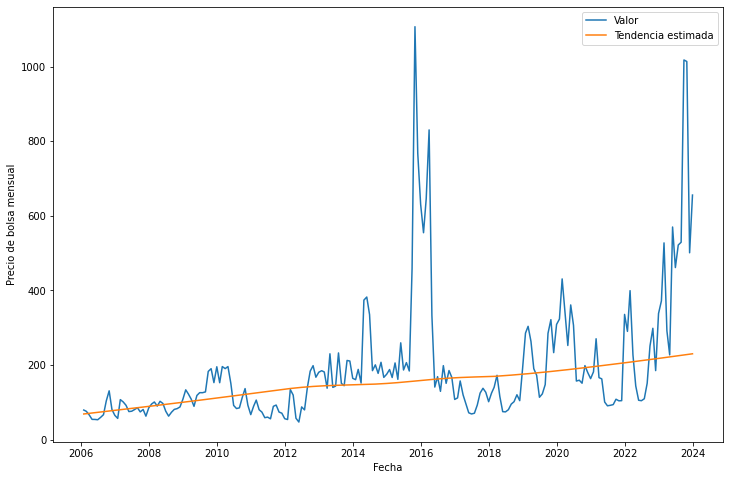

In [7]:
# Graficar la serie de tiempo y su tendencia estimada

# creando lienzo
plt.figure(figsize=(12, 8))

# creando gráfica
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Valor')


lowess = sm.nonparametric.lowess
smoothed = lowess(df_vcm['valor'], df_vcm['fechaoperacion'])
plt.plot(df_vcm['fechaoperacion'], smoothed[:, 1], label='Tendencia estimada')

#
plt.xlabel('Fecha')
plt.ylabel('Precio de bolsa mensual')
plt.legend()
plt.show()

### 5.3.3 Autocorrelación (ACF) y Autorcorrelación Parcial (PCAF)

Después de validar la estacionariedad de la serie temporal del precio de bolsa mensual, el siguiente paso en la metodología de Box-Jenkins es analizar la autocorrelación (ACF) y la autocorrelación parcial (PACF) de la serie. Este análisis nos ayuda a identificar el comportamiento y la estructura de dependencia temporal en los datos, facilitando la selección de los parámetros para los modelos ARIMA.

Para calcular y graficar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF), se utilizó el siguiente código:

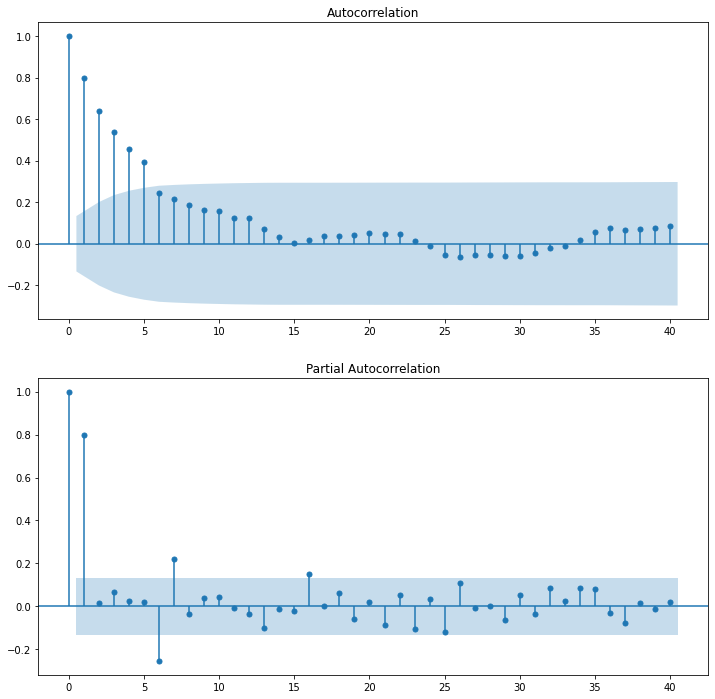

In [8]:
# Graficar ACF y PACF para la serie diferenciada

# creando lienzo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# realizando la autocorrelación
plot_acf(df_vcm['valor'].dropna(), lags=40, ax=ax1)

# realiznado la autocorrelación parcial
plot_pacf(df_vcm['valor'].dropna(), lags=40, ax=ax2)

# mostrando gráfico
plt.show()

- **Autocorrelación (ACF):**
El gráfico de la ACF muestra la correlación entre la serie temporal y sus rezagos hasta 40 períodos. La ACF es útil para identificar la presencia de componentes de media móvil (MA).

Observamos que las autocorrelaciones son significativas hasta el rezago 6, lo que sugiere que un modelo de media móvil de orden 6 (MA(6)) podría ser adecuado para capturar la dependencia temporal en los datos.

- **Autocorrelación Parcial (PACF):**
El gráfico de la PACF muestra la correlación parcial entre la serie temporal y sus rezagos, eliminando el efecto de los rezagos intermedios. La PACF es útil para identificar la presencia de componentes autoregresivos (AR).

Observamos que las autocorrelaciones parciales son significativas hasta el rezago 4, lo que sugiere que un modelo autoregresivo de orden 4 (AR(4)) podría ser adecuado para capturar la dependencia temporal en los datos.

Después de validar la estacionariedad de la serie temporal del precio de bolsa mensual y analizar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF), se procedió a la búsqueda del mejor modelo ARIMA. Aunque la serie temporal fue determinada como estacionaria, se identificó que presentaba una estacionariedad débil. Por lo tanto, se realizó una diferenciación adicional para mejorar la modelización.

Para encontrar el mejor modelo ARIMA, se utilizó la función auto_arima de la biblioteca pmdarima, que selecciona automáticamente el modelo más adecuado basado en criterios de información y pruebas estadísticas. El código utilizado es el siguiente:

In [9]:
from pmdarima.arima import auto_arima
import pandas as pd

# Suponiendo que dif_Indice_ts es tu serie temporal diferenciada
# Ajustar el modelo ARIMA automáticamente
modelo = auto_arima(df_vcm['valor'], seasonal=False, stepwise=True, suppress_warnings=True)

# Mostrar el resumen del modelo ajustado
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -1271.589
Date:                Sun, 23 Jun 2024   AIC                           2559.179
Time:                        20:03:19   BIC                           2586.144
Sample:                             0   HQIC                          2570.074
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3596      0.073    -18.499      0.000      -1.504      -1.216
ar.L2         -1.4133      0.110    -12.866      0.000      -1.629      -1.198
ar.L3         -0.9801      0.097    -10.062      0.0

- **Modelo SARIMAX(4, 1, 3):** Este modelo indica que el mejor ajuste para los datos se obtiene con un modelo autoregresivo de orden 4 (AR(4)), una diferenciación de orden 1, y una media móvil de orden 3 (MA(3)). La diferenciación de orden 1 se realizó para asegurar una mejor estacionariedad, dado que la serie original presentaba una estacionariedad débil.

- **Coeficientes y Significancia:** Los coeficientes de los términos AR y MA son estadísticamente significativos, como lo indica el valor de p (P>|z|) menor a 0.05 para cada coeficiente. Esto sugiere que los términos incluidos en el modelo son relevantes para explicar la variabilidad en los datos.

El análisis detallado de la autocorrelación y autocorrelación parcial, seguido de la búsqueda automática del mejor modelo ARIMA, permitió identificar el modelo SARIMAX(4, 1, 3) como el más adecuado para la serie temporal del precio de bolsa mensual. Este modelo tiene en cuenta la estructura temporal y la necesidad de diferenciación para alcanzar una mejor estacionariedad, garantizando una mayor precisión en las predicciones futuras.

### 5.3.4 Modelo ARIMA

Tras validar la estacionariedad de la serie temporal y analizar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF), se procedió a la modelización utilizando la metodología ARIMA. Se ajustaron y evaluaron dos modelos: SARIMAX(1, 0, 1) y SARIMAX(4, 1, 3). A continuación, se presentan los resultados obtenidos y su interpretación.

Para ajustar los modelos, se emplearon los siguientes códigos:

In [10]:
# Ajustar un modelo ARIMA(1,1,1) a la serie temporal, usando los parámetros sugeridos por los gráficos ACF y PACF
model = ARIMA(df_vcm['valor'], order=(1, 0, 1))
model_fit = model.fit()

# Mostrar el resumen del modelo ajustado
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  216
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1296.872
Date:                Sun, 23 Jun 2024   AIC                           2601.744
Time:                        20:03:24   BIC                           2615.245
Sample:                             0   HQIC                          2607.198
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        197.1948     69.402      2.841      0.004      61.169     333.221
ar.L1          0.8279      0.036     23.247      0.000       0.758       0.898
ma.L1         -0.0153      0.052     -0.296      0.767      -0.116       0.086
sigma2      9556.0915    416.420     22.948      0.000    8739.923    1.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2969.55
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              16.51   Skew:                             2.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- **Coeficientes:** El término AR(1) es significativo (p < 0.05), mientras que el término MA(1) no lo es.

- **AIC/BIC:** Los valores de AIC (2601.744) y BIC (2615.245) nos indican la calidad del ajuste del modelo, siendo AIC un indicador crucial para la selección de modelos.

In [11]:
# Ajustar un modelo ARIMA(4,1,3) a la serie temporal, usando los parámetros sugeridos por los gráficos ACF y PACF
model_vf = ARIMA(df_vcm['valor'].dropna(), order=(4, 1, 3))
model_fit_vf = model_vf.fit()

# Mostrar el resumen del modelo ajustado
model_fit_vf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  216
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1271.589
Date:                Sun, 23 Jun 2024   AIC                           2559.179
Time:                        20:03:27   BIC                           2586.144
Sample:                             0   HQIC                          2570.074
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3596      0.073    -18.499      0.000      -1.504      -1.216
ar.L2         -1.4133      0.110    -12.866      0.000      -1.629      -1.198
ar.L3         -0.9801      0.097    -10.062      0.000      -1.171      -0.789
ar.L4         -0.5078      0.042    -12.003      0.000      -0.591      -0.425
ma.L1          1.2854      0.086     14.867      0.000       1.116       1.455
ma.L2          1.0554      0.123      8.600      0.000       0.815       1.296
ma.L3          0.4069      0.122      3.333      0.001       0.168       0.646
sigma2      7977.5712    437.381     18.239      0.000    7120.321    8834.822
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1789.29
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              19.45   Skew:                             2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- **Coeficientes:** Todos los términos AR y MA son significativos (p < 0.05), indicando que estos términos son relevantes para el modelo.

- **AIC/BIC:** Los valores de AIC (2559.179) y BIC (2586.144) son menores comparados con el modelo ARIMA(1, 0, 1), sugiriendo un mejor ajuste del modelo.


Comparando los dos modelos ajustados, el modelo SARIMAX(4, 1, 3) presenta un mejor ajuste en términos de AIC y BIC, y todos sus coeficientes son significativos. 

Este análisis refuerza la elección del modelo SARIMAX(4, 1, 3) como el más adecuado para la serie temporal del precio de bolsa mensual, proporcionando una base sólida para las predicciones y análisis futuros en la metodología de Box-Jenkins.

### 5.3.5 Evaluación del modelo

- **Prueba de Ljung-Box:** La prueba de Ljung-Box evalúa si hay autocorrelación significativa en los residuos de un modelo ARIMA. Los resultados que has obtenido son los siguientes:

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Obtener los residuos del modelo ajustado
residuals = model_fit_vf.resid

# Prueba de Ljung-Box para autocorrelación en los residuos
ljung_box_result = acorr_ljungbox(residuals.dropna(), lags=[10, 20, 30], return_df=True)
print('Prueba de Ljung-Box:')
print(ljung_box_result)

Prueba de Ljung-Box:
      lb_stat  lb_pvalue
10   6.751698   0.748660
20  18.629080   0.546040
30  22.686147   0.827939


Los altos p-valores indican que no se rechaza la hipótesis nula de que no hay autocorrelación en los residuos a esos rezagos. En otras palabras, no hay evidencia significativa de autocorrelación en los residuos a los rezagos 10, 20, y 30. Esto sugiere que los residuos se comportan como ruido blanco, lo que es deseable y sugiere que el modelo ARIMA ajustado es adecuado.

- **Estadístico de Durbin-Watson:** El estadístico de Durbin-Watson se utiliza para detectar la autocorrelación de primer orden en los residuos de un modelo de regresión:

In [13]:
from statsmodels.stats.stattools import durbin_watson

# Prueba de Durbin-Watson para autocorrelación en los residuos
dw_stat = durbin_watson(residuals)
print(f'Estadístico de Durbin-Watson: {dw_stat}')

Estadístico de Durbin-Watson: 1.967331812982635


El valor del estadístico de Durbin-Watson varía entre 0 y 4:

- Un valor alrededor de 2 sugiere que no hay autocorrelación de primer orden en los residuos.
- Un valor cercano a 0 sugiere autocorrelación positiva.
- Un valor cercano a 4 sugiere autocorrelación negativa.

En este caso, el estadístico de Durbin-Watson es aproximadamente 2, lo que indica que no hay autocorrelación significativa de primer orden en los residuos. Esto es consistente con los resultados de la prueba de Ljung-Box y sugiere que los residuos son efectivamente ruido blanco.

Los resultados de la prueba de Ljung-Box y el estadístico de Durbin-Watson sugieren que los residuos del modelo ARIMA(4,1,3) no presentan autocorrelación significativa y se comportan como ruido blanco.

### 5.3.6 Prónostico ARIMA

Luego de ajustar el modelo SARIMAX(4, 1, 3) como el más adecuado para la serie temporal del precio de bolsa mensual, se realizaron predicciones para los próximos 12 meses. Este pronóstico es crucial para la planificación y toma de decisiones estratégicas en el mercado de energía.

Para generar las predicciones y visualizar los resultados, se utilizaron los siguientes bloques de código:

In [14]:
# Hacer predicciones con el modelo ARIMA ajustado para los próximos 12 períodos
forecast_12 = model_fit_vf.get_forecast(steps=12)
forecast_conf_int_12 = forecast_12.conf_int()

# Crear un DataFrame para visualizar las predicciones y los intervalos de confianza para 24 meses
forecast_df_12 = pd.DataFrame({
    'Predicted': forecast_12.predicted_mean,
    'Lower CI': forecast_conf_int_12.iloc[:, 0],
    'Upper CI': forecast_conf_int_12.iloc[:, 1]
})

forecast_df_12

,Predicted,Lower CI,Upper CI
216,798.637248,623.578654,973.695841
217,909.751931,671.188760,1148.315103
218,709.861294,444.123146,975.599442
219,605.610649,322.970212,888.251086
220,848.230405,544.214987,1152.245824
221,805.189202,456.522016,1153.856389
222,724.485901,358.304219,1090.667584
223,710.196044,329.526420,1090.865668
224,762.662978,359.652186,1165.673771
225,812.477149,388.151533,1236.802764


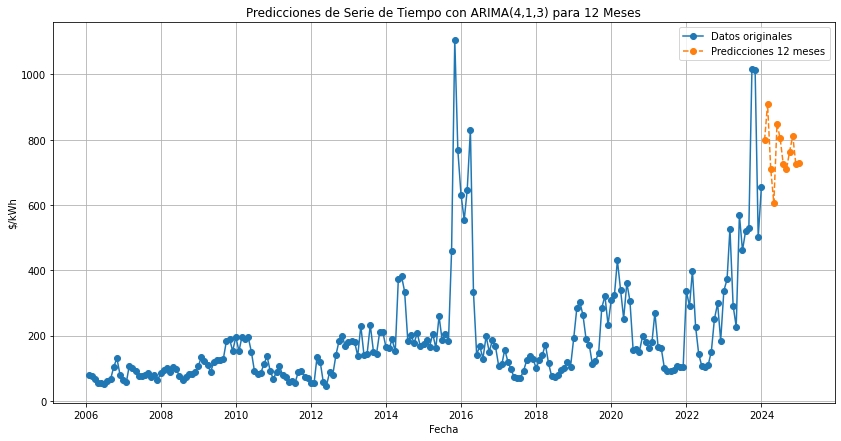

In [15]:
# Generar fechas de predicción para 24 meses
prediction_dates_12 = pd.date_range(start=df_vcm['fechaoperacion'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Graficar la serie original y las predicciones para 24 meses
plt.figure(figsize=(14, 7))
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Datos originales', marker='o')
plt.plot(prediction_dates_12, forecast_12.predicted_mean, label='Predicciones 12 meses', marker='o', linestyle='--')
plt.title('Predicciones de Serie de Tiempo con ARIMA(4,1,3) para 12 Meses')
plt.xlabel('Fecha')
plt.ylabel('$/kWh')
plt.legend()
plt.grid(True)
plt.show()

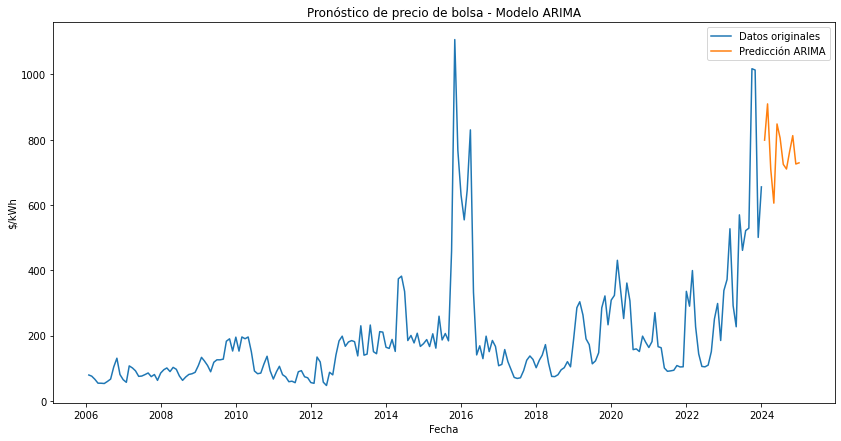

In [19]:
# Graficar la serie original y las predicciones para 24 meses
plt.figure(figsize=(14, 7))
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Datos originales')
plt.plot(prediction_dates_12, forecast_12.predicted_mean, label='Predicción ARIMA')
plt.title('Pronóstico de precio de bolsa - Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('$/kWh')
plt.legend()
plt.show()

- La gráfica muestra la serie temporal original y las predicciones para los próximos 12 meses.
- Las predicciones se visualizan con una línea de puntos, y los intervalos de confianza están representados por una sombra alrededor de las predicciones.
- Esto proporciona una representación visual clara de la tendencia futura esperada del precio de bolsa mensual y la incertidumbre asociada a estas predicciones.

El modelo SARIMAX(4, 1, 3) ha proporcionado un pronóstico robusto para los próximos 12 meses del precio de bolsa de energía. Las predicciones y sus intervalos de confianza permiten una evaluación detallada de las posibles variaciones futuras, proporcionando información valiosa para la planificación y toma de decisiones estratégicas en el mercado de energía.